# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

RANDOM_STATE = 42

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
for column in df.columns:
    print('\n', df[column].value_counts())


 31    496
32    477
34    466
33    464
35    461
     ... 
92      2
93      2
88      2
95      1
89      1
Name: age, Length: 76, dtype: int64

 management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

 married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

 secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

 no     10994
yes      168
Name: default, dtype: int64

 0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

 no     5881
yes    5281
Name: housing, dtype: int64

 n

### Задание 2

In [5]:
df.isnull().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

In [6]:
print(f"Number of 'unknown' jobs :{df[df['job'] == 'unknown'].shape[0]}")

Number of 'unknown' jobs :70


### Задание 3

In [7]:
df['balance'] = df[~df['balance'].isnull()]['balance'].apply(lambda x: float(x.replace(' ', '').replace(',', '.')[:-1]))
print(f"Mean of balance before filling NaNs: {round(df['balance'].mean(), 3)}")

Mean of balance before filling NaNs: 1529.129


### Задание 4

In [8]:
df['balance'] = df['balance'].fillna(df['balance'].median())
print(f"Mean of balance: {round(df['balance'].mean(), 3)}")

Mean of balance: 1526.936


### Задание 5

In [9]:
df['job'] = df['job'].replace({'unknown': df['job'].mode()[0]})
df['education'] = df['education'].replace({'unknown': df['education'].mode()[0]})
mask = (df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])
print(f"Mean of balance of clients with popular job and education: {round(df[mask]['balance'].mean(), 3)}")

Mean of balance of clients with popular job and education: 1598.883


### Задание 6

In [10]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    
    x = data[feature]
    quartile_1 = x.quantile(0.25)
    quartile_3 = x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lw_bound = quartile_1 - (iqr * left)
    up_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lw_bound) | (x > up_bound)]
    cleaned = data[(x >= lw_bound) & (x <= up_bound)]
    return outliers, cleaned, lw_bound, up_bound


outliers, df, lw, up = outliers_iqr_mod(df, 'balance')
print(f'Нижняя граница: {round(lw)}')
print(f'Верхняя граница: {round(up)}')
print(f'Число выбросов по методу Тьюки (1,5 * IQR): {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Нижняя граница: -2241
Верхняя граница: 4063
Число выбросов по методу Тьюки (1,5 * IQR): 1057
Результирующее число записей: 10105


### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

Text(0, 0.5, 'Count')

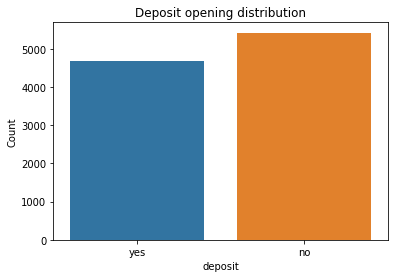

In [11]:
display(df['deposit'].value_counts())
pl = sns.countplot(x=df['deposit'])
pl.set_title('Deposit opening distribution')
pl.set_ylabel('Count')
# pl.legend();

### Задания 2 и 3

In [12]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Максимальный возраст клиентов банка составляет, лет: 95
Модальное значение возраста клиентов банка составляет, лет: 31
Медианное значение возраста клиентов банка составляет, лет: 38


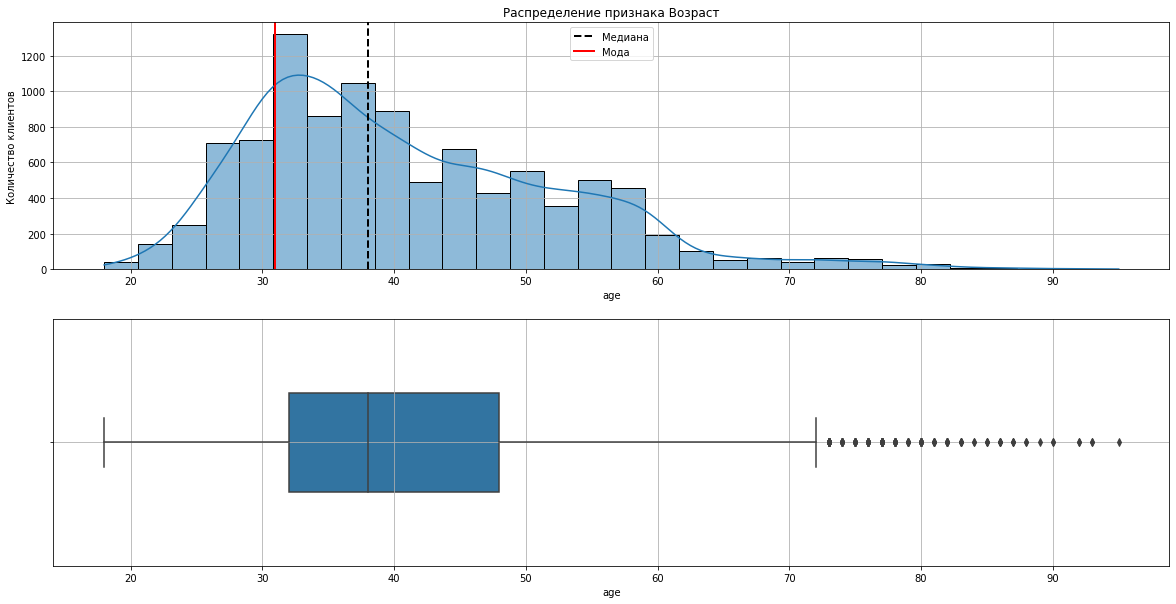

In [13]:
# возраст
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.histplot(
    data=df,
    x='age',
    bins=30,
    kde=True,
    ax=axes1[0]
)
sns.boxplot(
    data=df,
    x='age',
    orient='h',
    width=0.4,
    ax=axes1[1]
)
axes1[0].set_title('Распределение признака Возраст')
axes1[0].set_ylabel('Количество клиентов')
axes1[0].grid()
axes1[0].axvline(df['age'].median(), color='k', ls='--', lw=2, label='Медиана')
axes1[0].axvline(df['age'].mode()[0], color='r', lw=2, label='Мода')
axes1[0].legend(loc='upper center')
axes1[1].grid();

print('Максимальный возраст клиентов банка составляет, лет:', df['age'].max())
print('Модальное значение возраста клиентов банка составляет, лет:', df['age'].mode()[0])
print('Медианное значение возраста клиентов банка составляет, лет:', int(df['age'].median()))


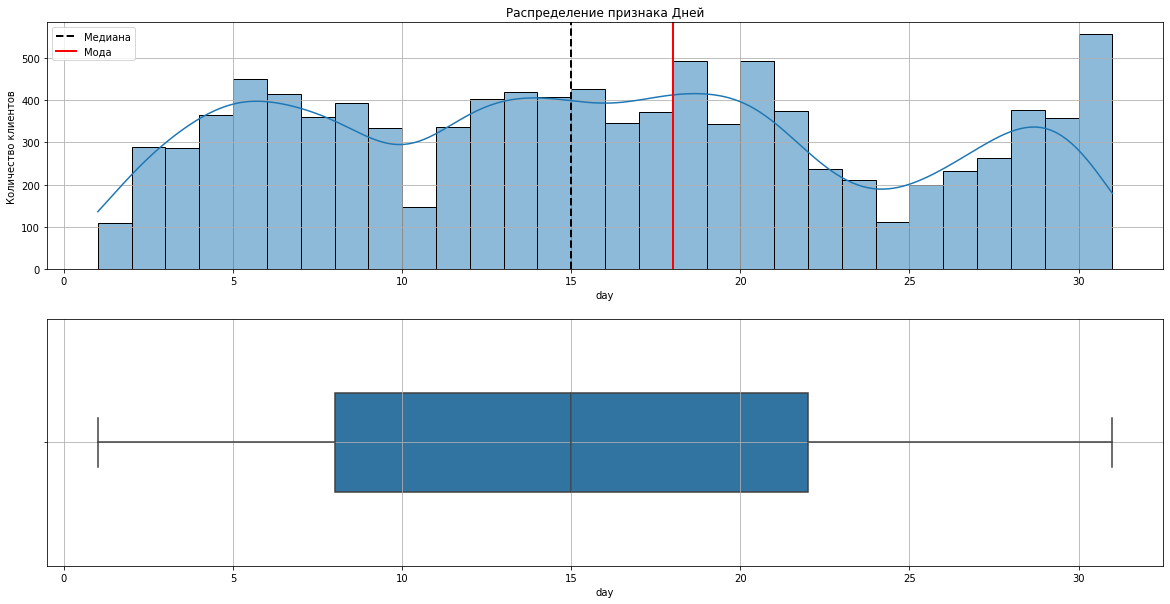

In [14]:
# дней
fig2, axes2 = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.histplot(
    data=df,
    x='day',
    bins=30,
    kde=True,
    ax=axes2[0]
)
sns.boxplot(
    data=df,
    x='day',
    orient='h',
    width=0.4,
    ax=axes2[1]
)
axes2[0].set_title('Распределение признака Дней')
axes2[0].set_ylabel('Количество клиентов')
axes2[0].grid()
axes2[0].axvline(df['day'].median(), color='k', ls='--', lw=2, label='Медиана')
axes2[0].axvline(df['day'].mode()[0], color='r', lw=2, label='Мода')
axes2[0].legend(loc='upper left')
axes2[1].grid();


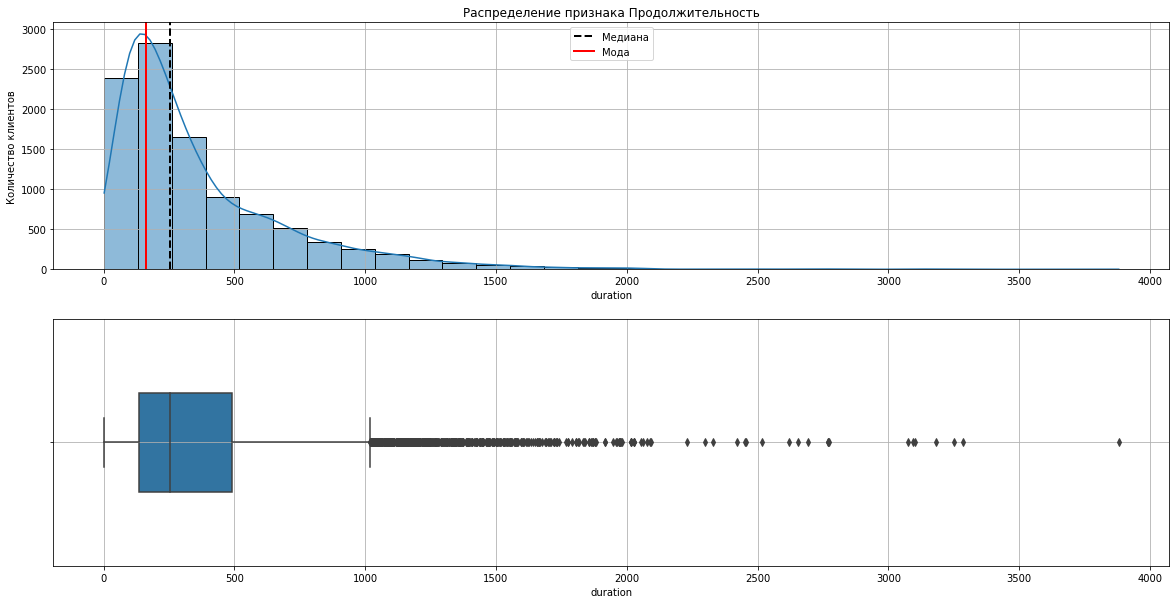

In [15]:
# продолжительность разговора
fig3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.histplot(
    data=df,
    x='duration',
    bins=30,
    kde=True,
    ax=axes3[0]
)
sns.boxplot(
    data=df,
    x='duration',
    orient='h',
    width=0.4,
    ax=axes3[1]
)
axes3[0].set_title('Распределение признака Продолжительность')
axes3[0].set_ylabel('Количество клиентов')
axes3[0].grid()
axes3[0].axvline(df['duration'].median(), color='k', ls='--', lw=2, label='Медиана')
axes3[0].axvline(df['duration'].mode()[0], color='r', lw=2, label='Мода')
axes3[0].legend(loc='upper center')
axes3[1].grid();


### Задания 4 и 5

In [16]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

rate_pivot = df.pivot_table(
    values='age',
    index='poutcome',
    columns='deposit',
    aggfunc='count'
)
rate_pivot['rate'] = rate_pivot['yes'] / (rate_pivot['yes'] + rate_pivot['no'])
rate_pivot['rate'].sort_values(ascending=False)

poutcome
success    0.911111
other      0.550936
failure    0.493237
unknown    0.397358
Name: rate, dtype: float64

### Задание 7

In [18]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

month_pivot = df.pivot_table(
    values='age',
    index='month',
    columns='deposit',
    aggfunc='count'
)
month_pivot['rate'] = month_pivot['no'] / (month_pivot['yes'] + month_pivot['no'])
month_pivot['rate'].sort_values(ascending=False)

month
may    0.678640
jan    0.608150
jul    0.589563
nov    0.584615
aug    0.559567
jun    0.548913
feb    0.455571
apr    0.381928
oct    0.185075
sep    0.165468
mar    0.101266
dec    0.096774
Name: rate, dtype: float64

### Задание 8

Text(0.5, 1.0, 'Соотношение клиентов, открывших / не открывших депозит по возрастным группам')

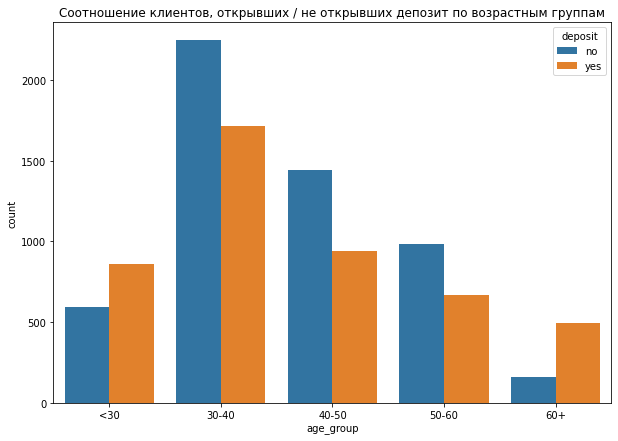

In [19]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_group (age):
    
    if age < 30:
        return'<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'

df['age_group'] = df['age'].apply(age_group)
age_group_df = df.groupby(['age_group', 'deposit']).count()
age_group_df = age_group_df.reset_index()[['age_group', 'deposit', 'age']]
age_group_df = age_group_df.rename(columns={'age': 'count'})

fig4 = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=age_group_df,
    x='age_group',
    y='count',
    hue='deposit',
    order=['<30', '30-40', '40-50', '50-60', '60+']
)
barplot.set_title('Соотношение клиентов, открывших / не открывших депозит по возрастным группам')

### Задания 9 и 10

Text(0.5, 1.0, 'Соотношение клиентов, открывших / не открывших депозит по семейному положению')

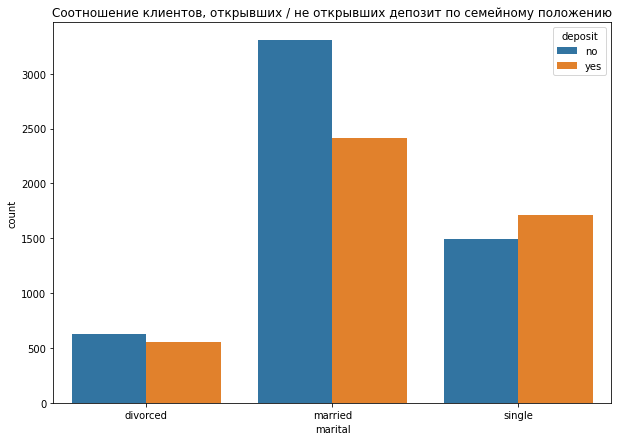

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

marital_group_df = df.groupby(['marital', 'deposit']).count()
marital_group_df = marital_group_df.reset_index()[['marital', 'deposit', 'age']]
marital_group_df = marital_group_df.rename(columns={'age': 'count'})

fig5 = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=marital_group_df,
    x='marital',
    y='count',
    hue='deposit',
    # order=['<30', '30-40', '40-50', '50-60', '60+']
)
barplot.set_title('Соотношение клиентов, открывших / не открывших депозит по семейному положению')

Text(0.5, 1.0, 'Соотношение клиентов, открывших / не открывших депозит по уровню образования')

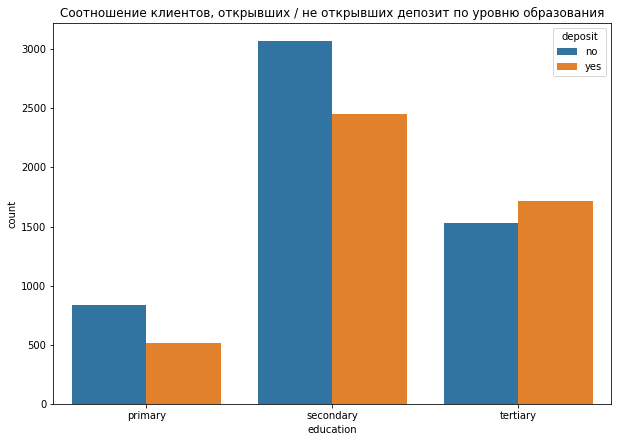

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

educ_group_df = df.groupby(['education', 'deposit']).count()
educ_group_df = educ_group_df.reset_index()[['education', 'deposit', 'age']]
educ_group_df = educ_group_df.rename(columns={'age': 'count'})

fig6 = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=educ_group_df,
    x='education',
    y='count',
    hue='deposit',
    # order=['<30', '30-40', '40-50', '50-60', '60+']
)
barplot.set_title('Соотношение клиентов, открывших / не открывших депозит по уровню образования')

Text(0.5, 1.0, 'Соотношение клиентов, открывших / не открывших депозит по виду профессиональной занятости')

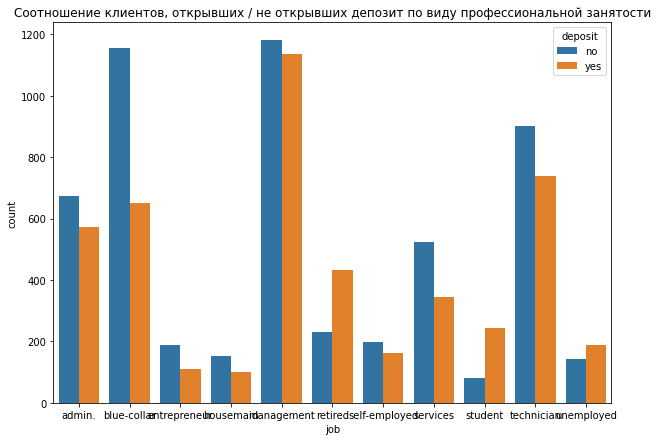

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

job_group_df = df.groupby(['job', 'deposit']).count()
job_group_df = job_group_df.reset_index()[['job', 'deposit', 'age']]
job_group_df = job_group_df.rename(columns={'age': 'count'})

fig7 = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=job_group_df,
    x='job',
    y='count',
    hue='deposit',
    # order=['<30', '30-40', '40-50', '50-60', '60+']
)
barplot.set_title('Соотношение клиентов, открывших / не открывших депозит по виду профессиональной занятости')

### Задание 11

In [23]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

pivot = df.pivot_table(
    values='age',
    index=['education', 'marital'],
    columns='deposit',
    aggfunc='count'
)

pivot['count'] = pivot['yes'] + pivot['no']
pivot.sort_values(by='count', ascending=False)


deposit               no   yes  count
education marital                    
secondary married   1830  1289   3119
          single     866   879   1745
tertiary  married    832   784   1616
          single     531   755   1286
primary   married    641   339    980
secondary divorced   370   283    653
tertiary  divorced   163   174    337
primary   divorced    91    96    187
          single     100    82    182

Text(0.5, 1.0, 'Распределение клиентов, не открывших депозит')

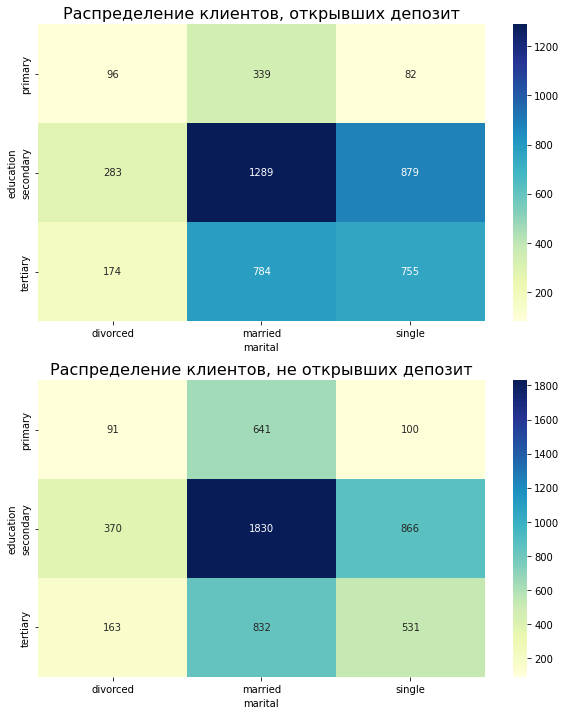

In [24]:
yes_pivot = df[df['deposit'] == 'yes'].pivot_table(
    values='age',
    index='education',
    columns='marital',
    aggfunc='count'
)
no_pivot = df[df['deposit'] == 'no'].pivot_table(
    values='age',
    index='education',
    columns='marital',
    aggfunc='count'
)

fig7, axes7 = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
sns.heatmap(
    data=yes_pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.4g',
    ax=axes7[0]
);
axes7[0].set_title('Распределение клиентов, открывших депозит', fontsize=16)
sns.heatmap(
    data=no_pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.4g',
    ax=axes7[1]
);
axes7[1].set_title('Распределение клиентов, не открывших депозит', fontsize=16)

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования

l_encoder = preprocessing.LabelEncoder()
df['educ_enc'] = l_encoder.fit_transform(df['education'])

print(f"Сумма получившихся значений для признака education: {df['educ_enc'].sum()}")

Сумма получившихся значений для признака education: 11995


### Задания 2 и 3

In [26]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df['age_group_enc'] = l_encoder.fit_transform(df['age_group'])
df['deposit'] = df['deposit'].replace({'no': 0, 'yes': 1})

print(f"Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit: {round(df['deposit'].std(), 3)}")

Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit: 0.499


In [27]:
df['default'] = df['default'].replace({'no': 0, 'yes': 1})
df['housing'] = df['housing'].replace({'no': 0, 'yes': 1})
df['loan'] = df['loan'].replace({'no': 0, 'yes': 1})

print(f"Сумма средних арифметических получившихся переменных: {round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)}")

Сумма средних арифметических получившихся переменных: 0.635


### Задание 4

In [28]:
# создайте дамми-переменные

df = pd.get_dummies(df, columns=['job'])
df = pd.get_dummies(df, columns=['marital'])
df = pd.get_dummies(df, columns=['contact'])
df = pd.get_dummies(df, columns=['month'])
df = pd.get_dummies(df, columns=['poutcome'])

df = df.drop(['education', 'age_group'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   default            10105 non-null  int64  
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  int64  
 4   loan               10105 non-null  int64  
 5   day                10105 non-null  int64  
 6   duration           10105 non-null  int64  
 7   campaign           10105 non-null  int64  
 8   pdays              10105 non-null  int64  
 9   previous           10105 non-null  int64  
 10  deposit            10105 non-null  int64  
 11  educ_enc           10105 non-null  int32  
 12  age_group_enc      10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

<AxesSubplot:>

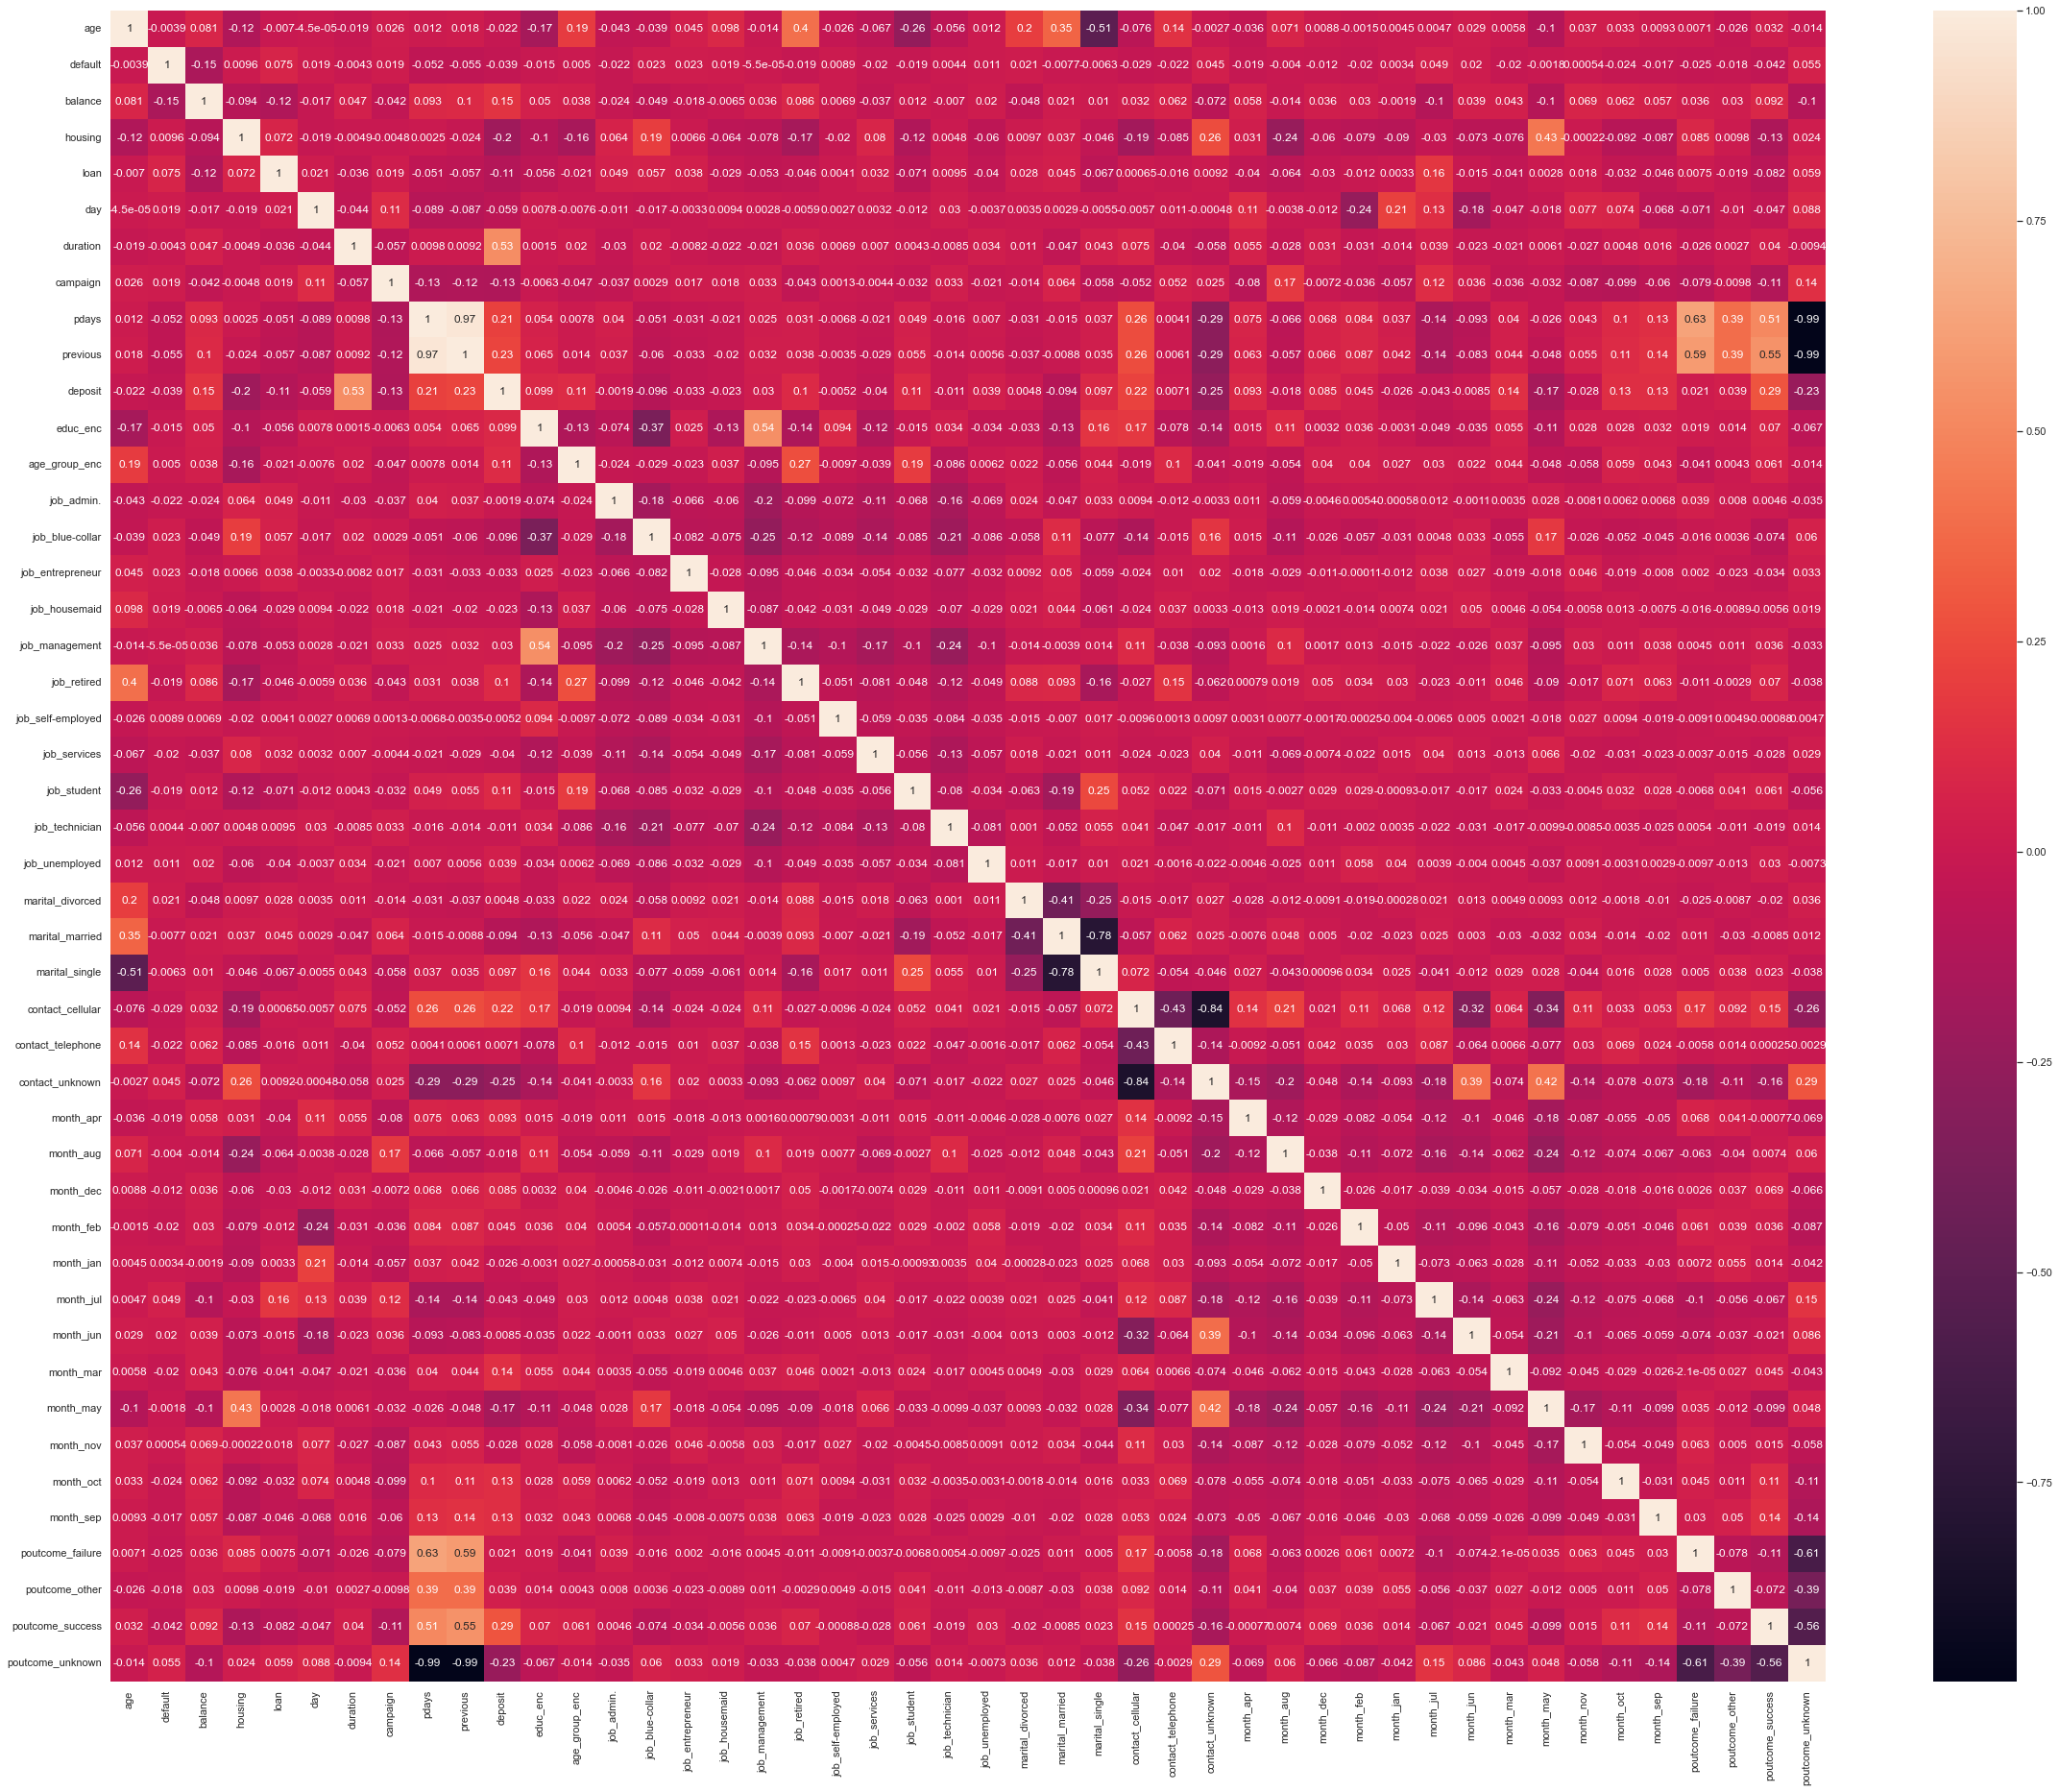

In [29]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

df_corr = df.corr(method='spearman')

sns.set(rc = {'figure.figsize':(40,32)})
sns.heatmap(df_corr, annot=True)

In [30]:
dep_corr = df_corr['deposit'].apply(lambda x: abs(x))
dep_corr = dep_corr.drop('deposit')
dep_corr.sort_values(ascending=False)

duration             0.532450
poutcome_success     0.288491
contact_unknown      0.249294
poutcome_unknown     0.228300
previous             0.227831
contact_cellular     0.223944
pdays                0.210149
housing              0.200290
month_may            0.168203
balance              0.150864
month_mar            0.135348
month_oct            0.130599
campaign             0.128754
month_sep            0.125239
age_group_enc        0.112607
loan                 0.107240
job_student          0.105563
job_retired          0.100090
educ_enc             0.098848
marital_single       0.097005
job_blue-collar      0.095845
marital_married      0.094246
month_apr            0.092888
month_dec            0.085041
day                  0.059139
month_feb            0.044728
month_jul            0.042779
job_services         0.040433
poutcome_other       0.039319
job_unemployed       0.039196
default              0.038872
job_entrepreneur     0.032706
job_management       0.029566
month_nov 

### Задания 7 и 8

In [31]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [32]:
# рассчитайте необходимые показатели

X_test.shape[0]

3335

In [33]:
round(y_test.mean(), 2)

0.46

### Задание 9

In [34]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# estimator_kbest = linear_model.LinearRegression()
selector_kbest = SelectKBest(f_classif, k=15)
selector_kbest = selector_kbest.fit(X_train, y_train)

columns_kbest = selector_kbest.get_feature_names_out()
print(columns_kbest)

X_train = X_train[columns_kbest]
X_test = X_test[columns_kbest]

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_group_enc' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 7287 to 4966
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           6770 non-null   float64
 1   housing           6770 non-null   int64  
 2   duration          6770 non-null   int64  
 3   campaign          6770 non-null   int64  
 4   pdays             6770 non-null   int64  
 5   previous          6770 non-null   int64  
 6   age_group_enc     6770 non-null   int32  
 7   contact_cellular  6770 non-null   uint8  
 8   contact_unknown   6770 non-null   uint8  
 9   month_mar         6770 non-null   uint8  
 10  month_may         6770 non-null   uint8  
 11  month_oct         6770 non-null   uint8  
 12  month_sep         6770 non-null   uint8  
 13  poutcome_success  6770 non-null   uint8  
 14  poutcome_unknown  6770 non-null   uint8  
dtypes: float64(1), int32(1), int64(5), uint8(8)
memory usage: 449.6 KB


### Задание 10

In [36]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


X_test_scaled.iloc[:, [0]].mean().round(2)

balance    0.47
dtype: float64

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [37]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(max_iter = 1000, solver='sag', random_state=RANDOM_STATE)
log_reg.fit(X_train_scaled, y_train)

y_test_pred_lr = log_reg.predict(X_test_scaled)
y_train_pred_lr = log_reg.predict(X_train_scaled)

print(f'accuracy на тренировочном наборе: {log_reg.score(X_train_scaled, y_train):.2f}')
print(f'f1_score на тренировочном наборе: {metrics.f1_score(y_train, y_train_pred_lr):.2f}')
print(f'accuracy на тестовом наборе: {log_reg.score(X_test_scaled, y_test):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred_lr):.2f}')

accuracy на тренировочном наборе: 0.82
f1_score на тренировочном наборе: 0.80
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78


### Задания 2,3,4

In [38]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE)
dt.fit(X_train_scaled, y_train)

y_test_pred_dt = dt.predict(X_test_scaled)
y_train_pred_dt = dt.predict(X_train_scaled)

print(f'accuracy на тренировочном наборе: {dt.score(X_train_scaled, y_train):.2f}')
print(f'f1_score на тренировочном наборе: {metrics.f1_score(y_train, y_train_pred_dt):.2f}')
print(f'accuracy на тестовом наборе: {dt.score(X_test_scaled, y_test):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred_dt):.2f}')

accuracy на тренировочном наборе: 1.00
f1_score на тренировочном наборе: 1.00
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.72


In [39]:
param_df = pd.DataFrame(columns=['max depth', 'train accuracy', 'test accuracy'])

for depth in range (1, 21):
    dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=depth)
    dt.fit(X_train_scaled, y_train)
    y_test_pred_dt = dt.predict(X_test_scaled)
    y_train_pred_dt = dt.predict(X_train_scaled)
    param_df.loc[len(param_df)] = [depth, dt.score(X_train_scaled, y_train), dt.score(X_test_scaled, y_test)]
    
param_df

,max depth,train accuracy,test accuracy
0,1.0,0.711521,0.706447
1,2.0,0.728804,0.717841
2,3.0,0.775775,0.770315
3,4.0,0.775923,0.769715
4,5.0,0.803840,0.793703
5,6.0,0.818316,0.808996
6,7.0,0.836484,0.818591
7,8.0,0.841654,0.811994
8,9.0,0.852290,0.810195
9,10.0,0.865436,0.803598


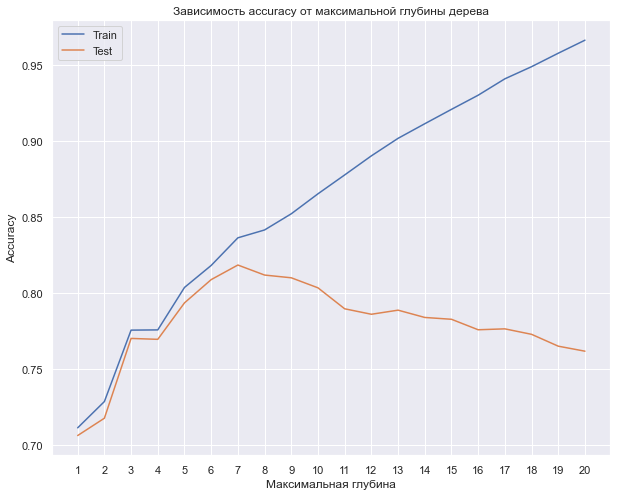

In [40]:
fig9, ax9 = plt.subplots(figsize=(10, 8)) #фигура + координатная плоскость
ax9.plot(param_df['max depth'], param_df['train accuracy'], label='Train')
ax9.plot(param_df['max depth'], param_df['test accuracy'], label='Test')

ax9.set_title('Зависимость accuracy от максимальной глубины дерева')
ax9.set_xlabel('Максимальная глубина')
ax9.set_ylabel('Accuracy')
ax9.set_xticks(param_df['max depth']) 
ax9.legend()

In [41]:
max_accuracy = param_df['test accuracy'].max()
opt_depth = int(param_df[param_df['test accuracy'] == max_accuracy]['max depth'])
print(f'Максимальное значение accuracy {round(max_accuracy, 2)} получается при глубине дерева {opt_depth}')

Максимальное значение accuracy 0.82 получается при глубине дерева 7


### Задание 5

In [42]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3, 5, 7]
}

grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5
)

%time grid_search_dt.fit(X_train_scaled, y_train)
y_test_pred_dt_gs = grid_search_dt.predict(X_test_scaled)

print(f'Наилучшие значения гиперпараметров: {grid_search_dt.best_params_}')
print(f'accuracy на тестовом наборе: {grid_search_dt.score(X_test_scaled, y_test):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred_dt_gs):.2f}')

CPU times: total: 766 ms
Wall time: 837 ms
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [43]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=RANDOM_STATE
)
rf.fit(X_train_scaled, y_train)

y_test_pred_rf = rf.predict(X_test_scaled)
y_train_pred_rf = rf.predict(X_train_scaled)

print(f'accuracy на тренировочном наборе: {rf.score(X_train_scaled, y_train):.2f}')
print(f'recall на тренировочном наборе: {metrics.recall_score(y_train, y_train_pred_rf):.2f}')
# print(f'f1_score на тренировочном наборе: {metrics.f1_score(y_train, y_train_pred_rf):.2f}')
print(f'accuracy на тестовом наборе: {rf.score(X_test_scaled, y_test):.2f}')
print(f'recall на тестовом наборе: {metrics.recall_score(y_test, y_test_pred_rf):.2f}')
# print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred_rf):.2f}')

accuracy на тренировочном наборе: 0.86
recall на тренировочном наборе: 0.86
accuracy на тестовом наборе: 0.83
recall на тестовом наборе: 0.83


### Задания 2 и 3

In [44]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=3,
    random_state=RANDOM_STATE
)

gb.fit(X_train_scaled, y_train)

y_test_pred_gb = gb.predict(X_test_scaled)
y_train_pred_gb = gb.predict(X_train_scaled)

print(f'accuracy на тренировочном наборе: {gb.score(X_train_scaled, y_train):.2f}')
# print(f'recall на тренировочном наборе: {metrics.recall_score(y_train, y_train_pred_gb):.2f}')
print(f'f1_score на тренировочном наборе: {metrics.f1_score(y_train, y_train_pred_gb):.2f}')
print(f'accuracy на тестовом наборе: {gb.score(X_test_scaled, y_test):.2f}')
# print(f'recall на тестовом наборе: {metrics.recall_score(y_test, y_test_pred_gb):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred_gb):.2f}')

accuracy на тренировочном наборе: 0.85
f1_score на тренировочном наборе: 0.85
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.81


### Задание 4

In [45]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimators = [
    ('dt', dt),
    ('lr', log_reg),
    ('gb', gb)
]

reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [46]:
y_test_pred_stack = reg.predict(X_test_scaled)
y_train_pred_stack = reg.predict(X_train_scaled)

print(f'accuracy на тренировочном наборе: {reg.score(X_train_scaled, y_train):.2f}')
print(f'precision на тренировочном наборе: {metrics.precision_score(y_train, y_train_pred_stack):.2f}')
# print(f'f1_score на тренировочном наборе: {metrics.f1_score(y_train, y_train_pred_stack):.2f}')
print(f'accuracy на тестовом наборе: {reg.score(X_test_scaled, y_test):.2f}')
print(f'precision на тестовом наборе: {metrics.precision_score(y_test, y_test_pred_stack):.2f}')


accuracy на тренировочном наборе: 0.85
precision на тренировочном наборе: 0.84
accuracy на тестовом наборе: 0.82
precision на тестовом наборе: 0.81


### Задание 5

In [55]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

imp_df = pd.Series(index=X_train.columns, data=gb.feature_importances_).sort_values(ascending=False)

imp_df

duration            0.556468
poutcome_success    0.118137
contact_unknown     0.073553
housing             0.051873
pdays               0.050107
age_group_enc       0.033615
month_mar           0.031261
balance             0.031057
month_oct           0.019535
month_sep           0.012854
month_may           0.008670
campaign            0.006992
previous            0.003672
contact_cellular    0.001725
poutcome_unknown    0.000481
dtype: float64

### Задания 6,7,8

In [54]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
    # создаем и обучаем модель
    model_optuna_rf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE
    )
    model_optuna_rf.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model_optuna_rf.predict(X_train_scaled))

    return score
  
# cоздаем объект исследования
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

print(f'Наилучшие значения гиперпараметров {study_rf.best_params}')
print(f'f1_score на обучающем наборе: {study_rf.best_value:.2f}')

# рассчитаем точность для тестовой выборки
model_opt_rf = ensemble.RandomForestClassifier(**study_rf.best_params, random_state=RANDOM_STATE)
model_opt_rf.fit(X_train_scaled, y_train)
y_train_pred_opt_rf = model_opt_rf.predict(X_train_scaled)
y_test_pred_opt_rf = model_opt_rf.predict(X_test_scaled)

print(f'accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred_opt_rf):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred_opt_rf):.2f}')

[I 2023-05-21 15:55:08,524] A new study created in memory with name: RandomForestClassifier
[I 2023-05-21 15:55:09,368] Trial 0 finished with value: 0.8680957596620248 and parameters: {'n_estimators': 170, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8680957596620248.
[I 2023-05-21 15:55:09,858] Trial 1 finished with value: 0.8510504860457824 and parameters: {'n_estimators': 119, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8680957596620248.
[I 2023-05-21 15:55:10,535] Trial 2 finished with value: 0.9241617047947353 and parameters: {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9241617047947353.
[I 2023-05-21 15:55:11,426] Trial 3 finished with value: 0.8629965592743197 and parameters: {'n_estimators': 194, 'max_depth': 21, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9241617047947353.
[I 2023-05-21 15:55:12,110] Trial 4 finished with value: 0.85029752583777 and parameters: {'n_es

Наилучшие значения гиперпараметров {'n_estimators': 120, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
